# Analysis of the Adult data set from UCI Machine Learning Repository

This is an analysis of the [Adult data set](http://archive.ics.uci.edu/ml/datasets/Adult) in the UCI Machine Learning Repository.

This data set is meant for binary class classification - to predict whether the income of a person exceeds 50K per year based on some census data.

## Preliminaries

First, we import the necessary libraries:

In [1]:
from IPython.display import display
from numpy.random import RandomState
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as pp


import numpy as np
import pandas as pd

We create a numpy.random.RandomState so that we can reproduce the same results each time we run this notebook.

In [2]:
rs = RandomState(121)

## Exploratory Data Analysis

This dataset is small and consists of 48842 rows with 14 columns (not counting the column giving the response variable). Hence we can load it entirely into memory. The fields of this data set are delimited by spaces; we can make use of pandas `read_csv` function to load it into memory as a dataframe.

In [3]:
X = pd.read_csv("Dataset.txt", header=None, delimiter=r"\s+",)

Let's take a look at the first few rows of the dataframe.

In [4]:
print(X.head())

   0          1       2             3   4                   5   \
0  25    Private  226802          11th   7       Never-married   
1  38    Private   89814       HS-grad   9  Married-civ-spouse   
2  28  Local-gov  336951    Assoc-acdm  12  Married-civ-spouse   
3  44    Private  160323  Some-college  10  Married-civ-spouse   
4  18          ?  103497  Some-college  10       Never-married   

                  6          7      8       9       10   11    12  \
0  Machine-op-inspct  Own-child  Black    Male     0.0  0.0  40.0   
1    Farming-fishing    Husband  White    Male     0.0  0.0  50.0   
2    Protective-serv    Husband  White    Male     0.0  0.0  40.0   
3  Machine-op-inspct    Husband  Black    Male  7688.0  0.0  40.0   
4                  ?  Own-child  White  Female     0.0  0.0  30.0   

              13     14  
0  United-States  <=50K  
1  United-States  <=50K  
2  United-States   >50K  
3  United-States   >50K  
4  United-States  <=50K  


Seems like everything is as according to the specifications. For ease of human consumption, we assign column names to the dataframe based on the specs.

In [5]:
X.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

See if there are any NaNs in the dataframe:

In [6]:
X.isnull().values.any()

True

Let's show the first few rows of the dataframe with the column names:

In [7]:
print(X.head())

   Age  WorkClass  fnlwgt     Education  EducationNum       MaritalStatus  \
0   25    Private  226802          11th             7       Never-married   
1   38    Private   89814       HS-grad             9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm            12  Married-civ-spouse   
3   44    Private  160323  Some-college            10  Married-civ-spouse   
4   18          ?  103497  Some-college            10       Never-married   

          Occupation Relationship   Race  Gender  CapitalGain  CapitalLoss  \
0  Machine-op-inspct    Own-child  Black    Male          0.0          0.0   
1    Farming-fishing      Husband  White    Male          0.0          0.0   
2    Protective-serv      Husband  White    Male          0.0          0.0   
3  Machine-op-inspct      Husband  Black    Male       7688.0          0.0   
4                  ?    Own-child  White  Female          0.0          0.0   

   HoursPerWeek  NativeCountry Income  
0          40.0  United-Stat

Let's take a look at the values of the `Income` column:

In [8]:
y = X["Income"].values
X.drop("Income", axis=1, inplace=True,)

Let's look at the data again:

In [9]:
print(X.head())

   Age  WorkClass  fnlwgt     Education  EducationNum       MaritalStatus  \
0   25    Private  226802          11th             7       Never-married   
1   38    Private   89814       HS-grad             9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm            12  Married-civ-spouse   
3   44    Private  160323  Some-college            10  Married-civ-spouse   
4   18          ?  103497  Some-college            10       Never-married   

          Occupation Relationship   Race  Gender  CapitalGain  CapitalLoss  \
0  Machine-op-inspct    Own-child  Black    Male          0.0          0.0   
1    Farming-fishing      Husband  White    Male          0.0          0.0   
2    Protective-serv      Husband  White    Male          0.0          0.0   
3  Machine-op-inspct      Husband  Black    Male       7688.0          0.0   
4                  ?    Own-child  White  Female          0.0          0.0   

   HoursPerWeek  NativeCountry  
0          40.0  United-States  
1 

Now, the `Age`, `fnlwgt`, `EducationNum`, `CapitalGain`, `CapitalLoss` and `HoursPerWeek` are clearly numerical. Let's get some summary statistics on these numerical columns:

In [10]:
X.describe()

,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek
count,8530.000000,8.530000e+03,8530.000000,8529.000000,8529.000000,8529.000000
mean,38.693552,1.882292e+05,10.060492,1128.986165,87.251847,40.436042
std,13.803450,1.051589e+05,2.574321,7903.709643,401.969239,12.429715
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.156770e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779815e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.374818e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3175.000000,99.000000


In [11]:
X.dtypes

Age                int64
WorkClass         object
fnlwgt             int64
Education         object
EducationNum       int64
MaritalStatus     object
Occupation        object
Relationship      object
Race              object
Gender            object
CapitalGain      float64
CapitalLoss      float64
HoursPerWeek     float64
NativeCountry     object
dtype: object

Let's convert the `Age`, `fnlwgt`, `EducationNum` and `HoursPerWeek` to floating point so scikit-learn / numpy won't complain about scaling later.

In [12]:
X.Age = X.Age.astype(float)
X.fnlwgt = X.fnlwgt.astype(float)
X.EducationNum = X.EducationNum.astype(float)
X.HoursPerWeek = X.HoursPerWeek.astype(float)

In [13]:
y.shape

(8530,)

In [14]:
X.shape

(8530, 14)

# Start from here!

preprocessing

In [15]:
# datada NaN değerler var mı?
print(X.isnull().sum())

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    1
Occupation       1
Relationship     1
Race             1
Gender           1
CapitalGain      1
CapitalLoss      1
HoursPerWeek     1
NativeCountry    1
dtype: int64


In [16]:
# numerik boş değerler doldurulur
X.fillna(X.mean(), inplace = True)
print(X.isnull().sum())

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    1
Occupation       1
Relationship     1
Race             1
Gender           1
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    1
dtype: int64


In [17]:
# kategorik boş değerler doldurulur
X.fillna(method = 'ffill', inplace = True)
print(X.isnull().sum())

Age              0
WorkClass        0
fnlwgt           0
Education        0
EducationNum     0
MaritalStatus    0
Occupation       0
Relationship     0
Race             0
Gender           0
CapitalGain      0
CapitalLoss      0
HoursPerWeek     0
NativeCountry    0
dtype: int64


In [18]:
# kategorik değerler numerik değerlere dönüştürülür
le = pp.LabelEncoder()
columns = ['WorkClass','Education','MaritalStatus','Occupation','Relationship','Race', 'Gender', 'NativeCountry']
for col in columns:
    le.fit(X[col])
    X[col] = le.transform(X[col]).astype(float)
print(X.head())

    Age  WorkClass    fnlwgt  Education  EducationNum  MaritalStatus  \
0  25.0        3.0  226802.0        1.0           7.0            4.0   
1  38.0        3.0   89814.0       11.0           9.0            2.0   
2  28.0        2.0  336951.0        7.0          12.0            2.0   
3  44.0        3.0  160323.0       15.0          10.0            2.0   
4  18.0        0.0  103497.0       15.0          10.0            4.0   

   Occupation  Relationship  Race  Gender  CapitalGain  CapitalLoss  \
0         7.0           3.0   2.0     1.0          0.0          0.0   
1         5.0           0.0   4.0     1.0          0.0          0.0   
2        11.0           0.0   4.0     1.0          0.0          0.0   
3         7.0           0.0   2.0     1.0       7688.0          0.0   
4         0.0           3.0   4.0     0.0          0.0          0.0   

   HoursPerWeek  NativeCountry  
0          40.0           38.0  
1          50.0           38.0  
2          40.0           38.0  
3       

In [19]:
# y datası içindeki boş değerler doldurulur
y = pd.DataFrame(y)
y.fillna(method = 'ffill', inplace = True)

In [20]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 41)

* Classifier 1 - Optimization (Use 5-fold Stratified CV with random_state= 41)
* After applying GridSearchCV to find the best parameters for your data, CREATE AN INSTANCE OF YOUR CLASSIFIER with the best parameters! 


In [51]:
pipe_svc = Pipeline([("scaler", StandardScaler()), ("linear_svc", SVC())])

param_grid_svc = {'linear_svc__gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100], 'linear_svc__decision_function_shape': ['ovo', 'ovr']}

search_svc = GridSearchCV(pipe_svc, param_grid_svc, cv = skf)
search_svc.fit(X, y)

print("Best parameter (CV score = %0.3f):" % search_svc.best_score_)
print(search_svc.best_params_)

/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Best parameter (CV score = 0.844):
{'linear_svc__decision_function_shape': 'ovo', 'linear_svc__gamma': 0.05}


In [52]:
svc = SVC(gamma = 0.05, decision_function_shape = 'ovo')

* Classifier 2 - Optimization (Use 5-fold Stratified CV with random_state= 41)
* After applying GridSearchCV to find the best parameters for your data, CREATE AN INSTANCE OF YOUR CLASSIFIER with the best parameters! 

In [53]:
pipe_nb = Pipeline([("scaler", StandardScaler()), ("naive_bayes", BernoulliNB())])

param_grid_nb = {'naive_bayes__fit_prior': [True, False], 'naive_bayes__alpha': [0, 0.5, 1]}

search_nb = GridSearchCV(pipe_nb, param_grid_nb, cv = skf)
search_nb.fit(X, y)

print("Best parameter (CV score = %0.3f):" % search_nb.best_score_)
print(search_nb.best_params_)

/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/zeynasip/anaconda3/lib/python3.7/sit

/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Best parameter (CV score = 0.801):
{'naive_bayes__alpha': 1, 'naive_bayes__fit_prior': True}


/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [54]:
naive_bayes = BernoulliNB(fit_prior = True, alpha = 1)

* Comparison of the two classifiers: (Make comparison based on the results of 5-fold Stratified CV with random_state= 41)

In [55]:
from sklearn.model_selection import cross_val_score

In [56]:
scores_svc = cross_val_score(svc, X, y, cv = skf)
print("Accuracy of SVC: %0.2f (+/- %0.2f)" % (scores_svc.mean(), scores_svc.std() * 2))

/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Accuracy of SVC: 0.77 (+/- 0.00)


In [57]:
scores_nb = cross_val_score(naive_bayes, X, y, cv = skf)
print("Accuracy of Bernoulli NB: %0.2f (+/- %0.2f)" % (scores_nb.mean(), scores_nb.std() * 2))

Accuracy of Bernoulli NB: 0.74 (+/- 0.02)


/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zeynasip/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

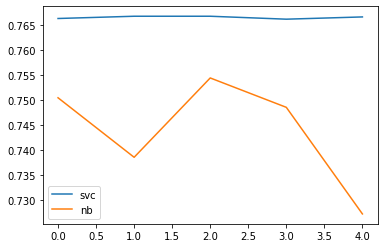

In [58]:
import matplotlib.pyplot as plt

plt.plot(scores_svc, label = 'svc')
plt.plot(scores_nb, label = 'nb')
plt.legend()